# Анализ лояльности пользователей Яндекс Афиши
###### Проект выполнил Udachin Kirill

##  Цель проекта

— провести исследовательский анализ данных сервиса Яндекс Афиша для изучения поведения пользователей и выявления факторов, влияющих на повторные покупки и удержание клиентов.

В рамках проекта необходимо:
- определить, какие характеристики первого заказа (тип мероприятия, устройство, регион, билетный оператор) связаны с вероятностью возврата пользователей;
- исследовать поведение клиентов через показатели выручки, среднее количество билетов и временные интервалы между заказами;
- изучить влияние временных характеристик (день недели, лайфтайм, интервалы между покупками) на удержание;
- провести корреляционный анализ признаков профиля пользователя и выявить факторы, связанные с числом заказов.

Результаты анализа помогут команде маркетинга выделить ключевые сегменты пользователей и разработать стратегии повышения лояльности и повторных продаж.


## Этапы выполнения проекта

###  Загрузка данных 

---

**Задача 1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. 

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


**Перед началом работы с данными загрузим все необходимые нам библиотеки.**

In [1]:
import pandas as pd

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

!pip install phik
import phik
from phik.report import plot_correlation_matrix

import seaborn as sns

import os

from dotenv import load_dotenv

In [2]:
load_dotenv('env_file')

True

In [3]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_user,
    db_password,
    db_host,
    db_port,
    db_name
)

In [5]:
engine = create_engine(connection_string)

In [6]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
),
joined AS (
  SELECT
      p.user_id,
      p.device_type_canonical,
      p.order_id,
      p.created_dt_msk,
      p.created_ts_msk,
      p.currency_code,
      p.revenue,
      p.tickets_count,
      p.event_id,
      p.service_name,
      e.event_name_code AS event_name,
      e.event_type_main,
      c.city_name,
      r.region_name
  FROM afisha.purchases p
  INNER JOIN afisha.events  e ON e.event_id  = p.event_id
  INNER JOIN afisha.city    c ON c.city_id   = e.city_id
  INNER JOIN afisha.regions r ON r.region_id = c.region_id
  WHERE p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
),
with_lag AS (
  SELECT
      j.*,
      LAG(j.created_dt_msk) OVER (
        PARTITION BY j.user_id
        ORDER BY j.created_dt_msk
      ) AS prev_created_dt
  FROM joined j
)
SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk AS order_dt,
    created_ts_msk AS order_ts,
    currency_code,
    revenue,
    tickets_count,
    (created_dt_msk::date - prev_created_dt::date) AS days_since_prev,
    event_id,
    event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM with_lag
ORDER BY user_id;
'''

In [7]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

**Изучим общую информацию о выгруженных данных.**

In [8]:
initial_rows = df.shape[0]

In [9]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Промежуточный вывод:**

Данные успешно выгружены из базы данных.

Размер таблицы: 290 611 строк × 15 столбцов.

Все ключевые поля (user_id, order_id, event_id, revenue, days_since_prev и др.) присутствуют.
Типы данных в целом корректны:
даты (order_dt, order_ts) уже приведены к типу datetime64[ns];
числовые значения (revenue, tickets_count, days_since_prev) — числовые типы (float64 / int64);
категориальные признаки (device_type_canonical, event_type_main, service_name, region_name, city_name) имеют тип object.

Пропуски присутствуют только в поле days_since_prev (около 7,5 %), что ожидаемо: это первые заказы пользователей, для которых нет предыдущих покупок.

Данные загружены корректно и готовы к дальнейшей предобработке.

In [11]:
initial_shape = df.shape

---

###  Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 3:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [12]:
tenge_rate = pd.read_csv('/datasets/final_tickets_tenge_df.csv')

In [13]:
tenge_rate.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [14]:
tenge_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Проверим валюты в наших данных:

In [15]:
print(df['currency_code'].value_counts())

rub    285542
kzt      5069
Name: currency_code, dtype: int64


Произведем конвертацию из тенге в рубли:

In [16]:
tenge_rate['data'] = pd.to_datetime(tenge_rate['data'], errors='coerce')

In [17]:
# Объединим df с курсами валют по дате заказа
df = df.merge(tenge_rate, how='left', left_on='order_dt', right_on='data')

In [18]:
# Рассчитаем выручку в рублях
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] / (row['curs'] / 100)
    if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1)

In [19]:
df[['currency_code', 'revenue', 'revenue_rub']].head()

,currency_code,revenue,revenue_rub
0,rub,1521.94,1521.94
1,rub,289.45,289.45
2,rub,1258.57,1258.57
3,rub,8.49,8.49
4,rub,1390.41,1390.41


В исходных данных использовались две валюты — российский рубль (RUB) и казахстанский тенге (KZT).С помощью датасета final_tickets_tenge_df.csv проведена конвертация значений выручки в единую валюту — рубли.

Новый столбец revenue_rub успешно добавлен в таблицу.
В дальнейшем анализе будем использовать именно этот столбец для расчётов.

---

**Задача 4:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [20]:
# Проверим количество пропусков по всем столбцам
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
data                         0
nominal                      0
curs                         0
cdx                          0
revenue_rub                  0
dtype: int64

In [21]:
#Удалим ненужные столбцы, которые попали из датасета final_tickets_tenge_df.csv
df = df.drop(columns=['data', 'nominal', 'curs', 'cdx'])

In [22]:
#Проверим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [23]:
#Проверим категориалные столбцы
for col in ['device_type_canonical', 'currency_code', 'event_type_main', 'service_name', 'region_name', 'city_name']:
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False).head(10))


device_type_canonical:
mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

currency_code:
rub    285542
kzt      5069
Name: currency_code, dtype: int64

event_type_main:
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

service_name:
Билеты без проблем    63519
Лови билет!           41124
Билеты в руки         40343
Мой билет             34839
Облачко               26642
Лучшие билеты         17774
Весь в билетах        16849
Прачечная             10273
Край билетов           6207
Тебе билет!            5228
Name: service_name, dtype: int64

region_name:
Каменевский регион         91058
Североярская область       44049
Широковская область        16457
Медовская область          13901
Озернинский край           10476
Светополянский округ        7607
Малиновоярский округ        6618
Речиновская область         6293
Солнечноземская область    

In [24]:
#Проверим числовые данные на выбросы
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,982.315796,2.754311
std,4702.383006,1.170620
min,-90.760000,1.000000
25%,116.990000,2.000000
50%,359.370000,3.000000
75%,822.610000,4.000000
max,133023.885631,57.000000


В revenue_rub обнаружено отрицательное значение (−90.76) — это явная ошибка данных.Н ужно удалить строки с отрицательной выручкой.

Максимум 133 023 руб. при среднем ~982 руб. говорит о сильных выбросах — логично будет обрезать по 99 перцентилю.

В столбце tickets_count максимум = 57 — подозрительно много, но не обязательно ошибка (возможно, корпоративные заказы).

In [25]:
#Удалим строки с отрицательной выручкой
df = df[df['revenue_rub'] >= 0]

In [26]:
#Обрежим данные по 99 перцентилю
p99 = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] <= p99]

In [27]:
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,287425.000000,287425.000000
mean,575.926268,2.753598
std,854.104501,1.172879
min,0.000000,1.000000
25%,116.450000,2.000000
50%,354.350000,3.000000
75%,805.110000,4.000000
max,18241.235273,57.000000


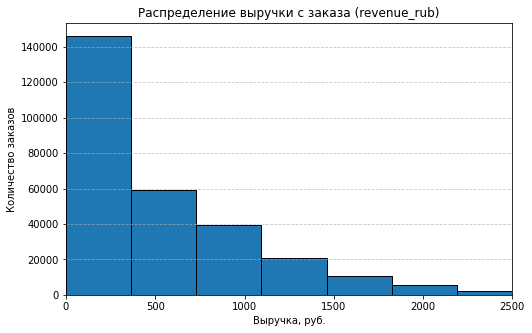

In [28]:
#Проверим полученные данные визуализацией
plt.figure(figsize=(8,5))
plt.hist(df['revenue_rub'], bins=50, edgecolor='black')
plt.title('Распределение выручки с заказа (revenue_rub)')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.xlim(0, 2500)  # чтобы не мешали редкие крупные значения
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

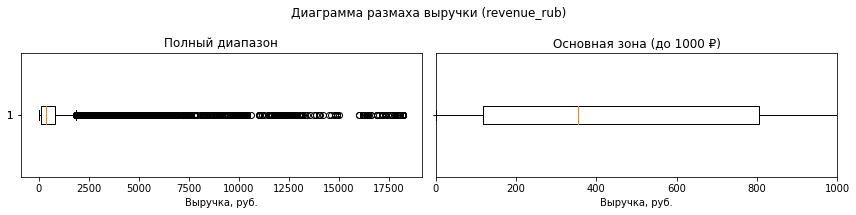

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
# Полный диапазон
axes[0].boxplot(df['revenue_rub'], vert=False)
axes[0].set_title('Полный диапазон')
axes[0].set_xlabel('Выручка, руб.')

# Усечённый диапазон до 1000 ₽
axes[1].boxplot(df['revenue_rub'], vert=False)
axes[1].set_xlim(0, 1000)
axes[1].set_title('Основная зона (до 1000 ₽)')
axes[1].set_xlabel('Выручка, руб.')

plt.suptitle('Диаграмма размаха выручки (revenue_rub)', fontsize=12)
plt.tight_layout()
plt.show()

Диаграммы размаха показывают, что распределение выручки имеет сильную правостороннюю асимметрию — большинство заказов приносят относительно небольшую сумму, а небольшое число заказов имеет очень большую выручку (до 18 000 ₽).

На первой диаграмме показан полный диапазон значений, где видно наличие множества выбросов.
На второй диаграмме ось X ограничена 1000 ₽, чтобы визуализировать основную массу данных.

Медиана ≈ 350–400 ₽

75 % заказов не превышают ≈ 800 ₽

Выбросы (более 1000 ₽) составляют малую долю, но сильно влияют на среднее значение

Таким образом, типичный заказ — это покупка на сумму до 800 ₽, но редкие крупные заказы существенно увеличивают среднюю выручку по выборке.

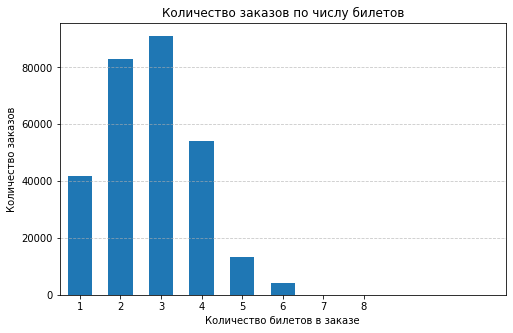

In [30]:
plt.figure(figsize=(8,5))
counts = df['tickets_count'].value_counts().sort_index()
plt.bar(counts.index, counts.values, width=0.6)
plt.title('Количество заказов по числу билетов')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')
plt.xticks(range(1, 9))     # отметки от 1 до 11
plt.xlim(0.5, 11.5)          # растягиваем ось X, чтобы крайние столбцы не обрезались
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

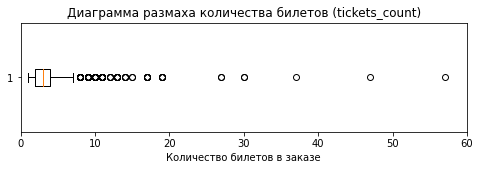

In [31]:
plt.figure(figsize=(8, 2))
plt.boxplot(df['tickets_count'], vert=False)
plt.title('Диаграмма размаха количества билетов (tickets_count)')
plt.xlabel('Количество билетов в заказе')
plt.xlim(0, 60)  # ограничим до 10, чтобы не мешали редкие крупные заказы
plt.show()

Анализ распределения количества билетов показывает, что подавляющее большинство заказов включает от 1 до 4 билетов.
На гистограмме видно резкое снижение частоты после значения 4, а единичные заказы содержат более 10 билетов.

Медиана: 3 билета

75-й перцентиль: 4 билета

Максимум: 57 билетов (редкие групповые покупки, вероятно корпоративные)

Распределение сильно смещено влево, большая концентрация около 2–3 билетов

Диаграмма размаха также подтверждает, что большинство заказов компактны, без существенных выбросов, за исключением редких крупных покупок.

Таким образом, типичный заказ — это 2–4 билета, что может указывать на покупки для небольшой компании (пары, семьи или группы друзей).

In [32]:
# Проверка явных дубликатов — полное совпадение строк 
full_dups = df[df.duplicated(keep=False)]
print(f"Количество полных дубликатов (полное совпадение строк): {full_dups.shape[0]}")

Количество полных дубликатов (полное совпадение строк): 0


In [33]:
# Проверка неявных дубликатов (совпадают ключевые признаки заказа)
key_cols = ["user_id", "event_id", "order_id"]

partial_dups = (
    df[df.duplicated(subset=key_cols, keep=False)]
    .sort_values(key_cols)
)

print(f"Количество неявных дубликатов по ключу {key_cols}: {partial_dups.shape[0]}")

Количество неявных дубликатов по ключу ['user_id', 'event_id', 'order_id']: 0


В ходе предобработки были выполнены две проверки:

- Явные дубликаты 

**Результат: 0 дубликатов**
  
- Неявные дубликаты   

**Результат: 0 дубликатов**

Дубликаты в данных отсутствуют, коррекция набора не требуется.

In [34]:
final_rows = df.shape[0]

In [35]:
# Фиксация потерь данных после предобработки
lost_rows = initial_rows - final_rows
lost_percent = (lost_rows / initial_rows * 100)

print(f"Количество наблюдений до предобработки: {initial_rows}")
print(f"Количество наблюдений после предобработки: {final_rows}")
print(f"Потеряно наблюдений: {lost_rows} ({lost_percent:.2f}%)")


Количество наблюдений до предобработки: 290611
Количество наблюдений после предобработки: 287425
Потеряно наблюдений: 3186 (1.10%)


**По итогам предобработки данных мы удалили 3186 строк, что составляет 1.10% и неявляется критичным. Отсутствие данного количества строк не исказит дальнейший анализ данных.**

**Промежуточный вывод по предобработке данных**

**1.Валюта:**

В исходных данных присутствовали заказы в российских рублях (rub) и казахстанских тенге (kzt).
На основе таблицы с курсом валют рассчитана новая колонка revenue_rub, где вся выручка приведена к рублям.
Для заказов в тенге произведена конвертация с учётом курса «рублей за 100 тенге» на дату заказа.

**2.Пропущенные значения:**

Пропуски зафиксированы только в поле days_since_prev — это ожидаемо, так как для первой покупки пользователя предыдущего заказа нет.
В остальных столбцах пропущенных данных не обнаружено.

**3.Типы данных:**

Даты (order_dt, order_ts, data) приведены к типу datetime64[ns].
Числовые значения (revenue_rub, tickets_count) имеют корректные типы (float и int).
Категориальные признаки (device_type_canonical, currency_code, event_type_main и т. д.) сохранены в строковом формате.

**4.Аномалии и выбросы:**

В поле revenue_rub присутствовали отдельные экстремальные значения (до ~133 тыс. руб.), нехарактерные для обычных покупок.
Для повышения точности анализа данные были отфильтрованы по 99-му перцентилю выручки.
**После фильтрации осталось ≈ 287 425 строк (удалено немного болеее 1 % данных).**

**5.Распределения:**

revenue_rub имеет асимметричное распределение с концентрацией заказов в диапазоне до 1 000 ₽.
tickets_count сосредоточен в пределах 1–4 билетов на заказ, что характерно для покупок на небольшие группы.

**6.Дубликаты:**

Дубликатов в данных, как явных, так и неявных, обнаружено не было. Удаление и корректировка строк не требуется.

**Итог:**
Данные очищены, приведены к единой валюте и готовы к исследовательскому анализу.
Добавлен новый столбец revenue_rub, отражающий выручку в рублях.
Выбросы по выручке устранены, структура таблицы соответствует ожиданиям **(290 611 → 287 425 строк).**

---

### Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 5.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [36]:
# Убедимся, что сортировка по пользователю и дате корректная
df = df.sort_values(by=['user_id', 'order_dt'])

In [37]:
# Группировка и построение профиля пользователя
user_profile = (
    df.groupby('user_id')
    .agg(
        first_order_dt=('order_dt', 'min'), # дата первого заказа
        last_order_dt=('order_dt', 'max'), # дата последнего заказа
        first_device=('device_type_canonical', 'first'), # устройство первого заказа
        first_region=('region_name', 'first'), # регион первого заказа
        first_service=('service_name', 'first'), # билетный партнёр первого заказа
        first_genre=('event_type_main', 'first'), # жанр первого мероприятия
        total_orders=('order_id', 'nunique'), # общее количество заказов
        avg_revenue=('revenue_rub', 'mean'), # средняя выручка
        avg_tickets=('tickets_count', 'mean'), # среднее число билетов
        avg_days_between=('days_since_prev', 'mean') # среднее время между заказами
)
    .reset_index()
)

In [38]:
# Добавим бинарные признаки:
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [39]:
# Проверим результат
user_profile.head(10)

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_genre,total_orders,avg_revenue,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000000,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000000,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.000000,1,0
7,0018ecd8a38a51b,2024-07-25,2024-07-25,mobile,Медовская область,Билеты без проблем,спорт,1,0.000000,3.000000,NaN,0,0
8,00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120000,4.000000,NaN,0,0
9,001e7037d013f0f,2024-07-04,2024-09-29,mobile,Златопольский округ,Мой билет,другое,3,326.623333,1.333333,43.500000,1,0


---

**Задача 6.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [40]:
# Общее количество пользователей
total_users = user_profile['user_id'].nunique()

In [41]:
# Средняя выручка с одного заказа
avg_revenue_per_order = df['revenue_rub'].mean()

In [42]:
# Доля пользователей с ≥2 заказами
share_two = user_profile['is_two'].mean()
# Доля пользователей с ≥5 заказами
share_five = user_profile['is_five'].mean()

In [43]:
print(f"Общее число пользователей: {total_users:}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с ≥2 заказами: {share_two:.2%}")
print(f"Доля пользователей с ≥5 заказами: {share_five:.2%}")

Общее число пользователей: 21719
Средняя выручка с одного заказа: 575.93 руб.
Доля пользователей с ≥2 заказами: 61.75%
Доля пользователей с ≥5 заказами: 29.12%


In [44]:
#Статистики по числовым характеристикам профиля
user_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)

,total_orders,avg_tickets,avg_days_between
count,21719.00,21719.00,13462.00
mean,13.23,2.75,16.00
std,122.22,0.93,22.47
min,1.00,1.00,0.00
25%,1.00,2.00,1.00
50%,2.00,2.75,8.17
75%,5.00,3.12,20.67
max,10195.00,12.00,148.00


В базе данных содержится информация о 21 719 пользователях, из которых 13 462 совершали повторные покупки (имеют рассчитанный промежуток между заказами).

Основные наблюдения:

Среднее количество заказов на пользователя: 13,2
Однако медиана — всего 2 заказа, что говорит о сильном перекосе (наличии активных пользователей с тысячами заказов, которые искажают среднее).
→ распределение сильно асимметрично, большинство клиентов совершают 1–5 заказов.

Среднее количество билетов в заказе: 2,75
Типичный пользователь покупает 2–3 билета за раз, максимум — 12 (редкие групповые покупки).

Среднее время между заказами: 16 дней
Медианное значение — около 8 дней, что указывает на быстрые возвраты части пользователей, но также есть периоды до 148 дней (редкие, долгие возвраты).

Выбросы:
Количество заказов до 10 195 явно аномально, это могут быть корпоративные клиенты.
Для дальнейшего анализа можно рассмотреть фильтрацию данных по 99-му перцентилю.

In [45]:
# Определяем порог по 99 перцентилю
threshold = user_profile['total_orders'].quantile(0.99)

# Фильтруем аномалии
filtered_profile = user_profile[user_profile['total_orders'] <= threshold]

# Проверим объём после фильтрации
filtered_profile.shape[0], user_profile.shape[0]

(21501, 21719)

Было 21719 пользователей, а стало 21051. Удалено менее 1 процента даннх

In [46]:
#Создадим отфильтрованный профиль
filtered_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)

,total_orders,avg_tickets,avg_days_between
count,21501.00,21501.00,13244.00
mean,6.50,2.75,16.25
std,14.26,0.93,22.56
min,1.00,1.00,0.00
25%,1.00,2.00,1.40
50%,2.00,2.76,8.50
75%,5.00,3.14,21.00
max,151.00,12.00,148.00


---

### Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



####  Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 7.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Для анализа распределения пользователей по сегментам используем профиль пользователя user_profile.
Этот набор данных содержит всех пользователей, включая редкие и аномальные случаи, что позволяет корректно оценить общую структуру аудитории и выявить основные «точки входа» — сегменты, через которые пользователи чаще всего совершают первый заказ.


In [47]:
# По типу первого мероприятия
event_type_stats = (
    user_profile.groupby('first_genre')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'users_count'})
)
event_type_stats['percent'] = (
    event_type_stats['users_count'] / event_type_stats['users_count'].sum() * 100
).round(2)

event_type_stats.sort_values('users_count', ascending=False)

,users_count,percent
first_genre,,
концерты,9388,43.22
другое,5530,25.46
театр,4351,20.03
стендап,1137,5.24
спорт,811,3.73
выставки,408,1.88
ёлки,94,0.43


In [48]:
# По типу устройства
device_stats = (
    user_profile.groupby('first_device')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'users_count'})
)
device_stats['percent'] = (
    device_stats['users_count'] / device_stats['users_count'].sum() * 100
).round(2)

device_stats.sort_values('users_count', ascending=False)

,users_count,percent
first_device,,
mobile,17986,82.81
desktop,3733,17.19


In [49]:
# По региону
region_stats = (
    user_profile.groupby('first_region')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'users_count'})
)
region_stats['percent'] = (
    region_stats['users_count'] / region_stats['users_count'].sum() * 100
).round(2)

region_stats.sort_values('users_count', ascending=False).head(10)

,users_count,percent
first_region,,
Каменевский регион,7257,33.41
Североярская область,3828,17.63
Широковская область,1258,5.79
Озернинский край,684,3.15
Малиновоярский округ,540,2.49
Травяная область,495,2.28
Светополянский округ,480,2.21
Речиновская область,447,2.06
Яблоневская область,417,1.92


In [50]:
# По билетному оператору
service_stats = (
    user_profile.groupby('first_service')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'users_count'})
)
service_stats['percent'] = (
    service_stats['users_count'] / service_stats['users_count'].sum() * 100
).round(2)

service_stats.sort_values('users_count', ascending=False).head(10)

,users_count,percent
first_service,,
Билеты без проблем,5227,24.07
Лови билет!,2887,13.29
Мой билет,2699,12.43
Билеты в руки,2601,11.98
Облачко,2222,10.23
Весь в билетах,1335,6.15
Лучшие билеты,1193,5.49
Прачечная,589,2.71
Край билетов,466,2.15


**Исследование распределения пользователей по признакам первого заказа:**

**1.Тип первого мероприятия:**

Распределение пользователей по жанрам первого мероприятия выражено неравномерно:
Концерты — 43,2% пользователей;
Другое (непопавшие в основные категории мероприятия) — 25,5%;
Театр — 20,0%;
Остальные категории («стендап», «спорт», «выставки», «ёлки») занимают менее 10% совокупно.

📍 Вывод: концерты — основная «точка входа» на платформу. Театр и универсальная категория «другое» также привлекают заметную долю новых пользователей.

**2.Тип устройства:**

Большинство первых покупок совершается с мобильных устройств — 82,8% против 17,2% с десктопов.

📍 Вывод: мобильный сегмент — ключевой канал взаимодействия с пользователями.

**3.Регион проведения мероприятия:**

Наиболее активные регионы по первому заказу:
Каменевский регион — 33,4%;
Североярская область — 17,6%;
Остальные регионы имеют долю менее 6% каждый.

📍 Вывод: активность пользователей сконцентрирована в нескольких крупных регионах.

**4.Билетный оператор:**

Самые популярные операторы при первом заказе:
Билеты без проблем — 24,1%;
Лови билет!, Мой билет, Билеты в руки — по 12–13% каждый;
Остальные операторы имеют долю менее 10%.

📍 Вывод: у пользователей есть чёткие предпочтения в выборе операторов.
Лидеры рынка (“Билеты без проблем” и “Лови билет!”) — главные точки входа для новых клиентов.

**Итог:**

Распределение пользователей неравномерное по всем признакам.
Выраженные «точки входа» наблюдаются:

по типу мероприятия — концерты;

по устройствам — мобильные;

по регионам — Каменевский регион;

по билетным операторам — “Билеты без проблем” и “Лови билет!”.

Эти сегменты формируют основное “входное окно” на платформу и должны стать приоритетом для маркетинговых кампаний по удержанию и повторным продажам.


**Задача 8.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [51]:
# Доля вернувшихся пользователей (2+ заказов) по жанру
genre_returns = (
    user_profile.groupby('first_genre')
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)
genre_returns['return_rate'] = (genre_returns['return_rate'] * 100).round(2)

genre_returns.sort_values('return_rate', ascending=False)

,users_count,return_rate
first_genre,,
театр,4351,64.08
выставки,408,63.73
концерты,9388,62.14
стендап,1137,61.57
другое,5530,60.09
спорт,811,56.23
ёлки,94,54.26


Text(0.5, 0, 'Доля возврата')

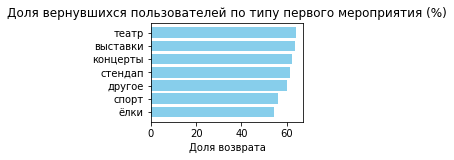

In [52]:
plt.subplot(2, 2, 1)
plt.barh(genre_returns.sort_values('return_rate')['return_rate'].index,
         genre_returns.sort_values('return_rate')['return_rate'], color='skyblue')
plt.title('Доля вернувшихся пользователей по типу первого мероприятия (%)')
plt.xlabel('Доля возврата')

In [53]:
# Доля вернувшихся пользователей по типу устройства
device_returns = (
    user_profile.groupby('first_device')
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)
device_returns['return_rate'] = (device_returns['return_rate'] * 100).round(2)

device_returns

,users_count,return_rate
first_device,,
desktop,3733,64.16
mobile,17986,61.25


Text(0.5, 0, 'Доля возврата')

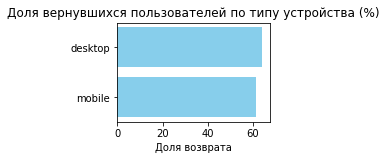

In [54]:
plt.subplot(2, 2, 2)
plt.barh(device_returns.sort_values('return_rate')['return_rate'].index,
         device_returns.sort_values('return_rate')['return_rate'], color='skyblue')
plt.title('Доля вернувшихся пользователей по типу устройства (%)')
plt.xlabel('Доля возврата')

In [55]:
# Доля вернувшихся пользователей по регионам — только топ-10 по числу пользователей
region_returns = (
    user_profile.groupby('first_region')
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)
region_returns['return_rate'] = (region_returns['return_rate'] * 100).round(2)
region_top10 = region_returns.sort_values('users_count', ascending=False).head(10)

region_top10

,users_count,return_rate
first_region,,
Каменевский регион,7257,62.97
Североярская область,3828,64.42
Широковская область,1258,65.34
Озернинский край,684,55.41
Малиновоярский округ,540,56.48
Травяная область,495,62.02
Светополянский округ,480,66.88
Речиновская область,447,64.43
Яблоневская область,417,59.71


Text(0.5, 0, 'Доля возврата')

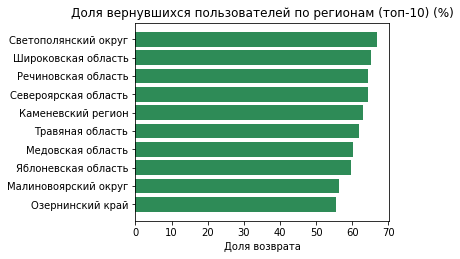

In [56]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 3)
plt.barh(region_top10.sort_values('return_rate')['return_rate'].index,
         region_top10.sort_values('return_rate')['return_rate'], color='seagreen')
plt.title('Доля вернувшихся пользователей по регионам (топ-10) (%)')
plt.xlabel('Доля возврата')

In [57]:
# По билетным операторам — только топ-10
service_returns = (
    user_profile.groupby('first_service')
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)
service_returns['return_rate'] = (service_returns['return_rate'] * 100).round(2)
service_top10 = service_returns.sort_values('users_count', ascending=False).head(10)

service_top10

,users_count,return_rate
first_service,,
Билеты без проблем,5227,60.82
Лови билет!,2887,61.93
Мой билет,2699,59.47
Билеты в руки,2601,63.48
Облачко,2222,62.02
Весь в билетах,1335,63.90
Лучшие билеты,1193,61.61
Прачечная,589,62.65
Край билетов,466,65.88


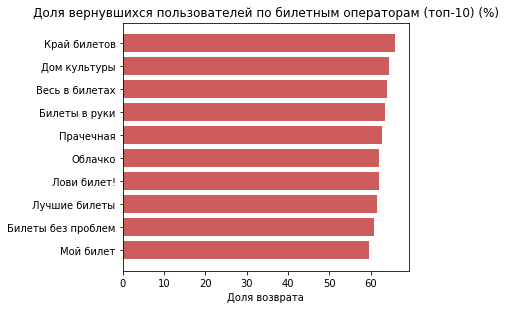

In [58]:
plt.figure(figsize=(10, 8)) 
plt.subplot(2, 2, 4)
plt.barh(service_top10.sort_values('return_rate')['return_rate'].index,
         service_top10.sort_values('return_rate')['return_rate'], color='indianred')
plt.title('Доля вернувшихся пользователей по билетным операторам (топ-10) (%)')
plt.xlabel('Доля возврата')

plt.tight_layout()
plt.show()

**Анализ возвратов пользователей:**

**1.По типу мероприятия:**

Наиболее часто возвращаются пользователи, впервые посетившие театр (64,1%), выставки (63,7%) и концерты (62,1%).
Это говорит о том, что события с высоким культурным или эмоциональным вовлечением стимулируют повторные заказы.
Самые низкие показатели у категорий «спорт» (56,2%) и «ёлки» (54,3%) — это, вероятно, разовые сезонные покупки.

**2.По типу устройства:**

Пользователи, совершающие первый заказ с desktop (64,2%), возвращаются немного чаще, чем пользователи мобильных устройств (61,3%).
Это может отражать более вдумчивое поведение аудитории за компьютером 

**3.По регионам:**

Самые высокие доли возврата наблюдаются в Светополянском округе (66,9%), Широковской области (65,3%) и Североярской области (64,4%).
Это могут быть ключевые регионы с более устойчивой пользовательской базой.
В то же время Озернинский край (55,4%) и Малиновоярский округ (56,5%) показывают наименьшую лояльность.

**4.По билетным операторам:**

Выше среднего удержание у пользователей сервисов «Край билетов» (65,9%), «Дом культуры» (64,4%) и «Билеты в руки» (63,5%).
Это можно считать «успешными точками входа».
Ниже среднего удержание у «Мой билет» (59,5%) и «Билеты без проблем» (60,8%).

**Итог:**

В среднем по выборке около 62% пользователей совершают повторный заказ.
Выраженные «точки входа» наблюдаются:

по типу мероприятий — театр и выставки;

по устройствам — desktop;

по регионам — Светополянский округ и Широковская область;

по операторам — Край билетов и Дом культуры.



---

**Задача 9.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [59]:
# Проверка гипотезы 1 — возвраты по типу первого мероприятия
genre_return_table = (
    user_profile.groupby('first_genre', as_index=False)
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)

# Рассчитаем долю возврата в процентах
genre_return_table['return_rate'] = (genre_return_table['return_rate'] * 100).round(2)

# Сортировка по числу пользователей (по убыванию)
genre_return_table = genre_return_table.sort_values('users_count', ascending=False)

genre_return_table

,first_genre,users_count,return_rate
2,концерты,9388,62.14
1,другое,5530,60.09
5,театр,4351,64.08
4,стендап,1137,61.57
3,спорт,811,56.23
0,выставки,408,63.73
6,ёлки,94,54.26


Предполагалось, что пользователи, начавшие с посещения спортивных мероприятий, совершают повторный заказ чаще, чем те, кто начал с концертов.

**Результаты анализа:**
- Доля вернувшихся после первого заказа на **спортивные мероприятия** — около **56%**.  
- Доля вернувшихся после **концертов** — около **62%**.  

**Вывод:** пользователи, начавшие с концертов, возвращаются чаще, чем спортивные зрители.  
Гипотеза **не подтвердилась**.

In [60]:
# Проверка гипотезы 2 - связь между активностью региона и долей возвратов

# Подсчёт общего числа пользователей
total_users = user_profile['user_id'].nunique()

# Сводка по регионам
region_activity = (
    user_profile.groupby('first_region')
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

# Добавляем долю пользователей (в %)
region_activity['users_share'] = (region_activity['users_count'] / total_users * 100).round(2)
region_activity['return_rate'] = (region_activity['return_rate'] * 100).round(2)

# Отбираем регионы с наибольшим числом пользователей
region_activity_top = region_activity.sort_values('users_count', ascending=False).head(10)

# Добавим строку "Остальные регионы" для наглядности
others = pd.DataFrame({
    'first_region': ['Остальные регионы'],
    'users_count': [region_activity['users_count'].iloc[10:].sum()],
    'return_rate': [round(region_activity['return_rate'].iloc[10:].mean(), 2)],
    'users_share': [round(100 - region_activity_top['users_share'].sum(), 2)]
})

# Объединяем таблицы
region_summary = pd.concat([region_activity_top, others], ignore_index=True)

# Приводим к нужному виду
region_summary['users_share'] = region_summary['users_share'].astype(str) + '%'
region_summary['return_rate'] = region_summary['return_rate'].astype(str) + '%'

region_summary[['first_region', 'users_share', 'return_rate']]

,first_region,users_share,return_rate
0,Каменевский регион,33.41%,62.97%
1,Североярская область,17.63%,64.42%
2,Широковская область,5.79%,65.34%
3,Озернинский край,3.15%,55.41%
4,Малиновоярский округ,2.49%,56.48%
5,Травяная область,2.28%,62.02%
6,Светополянский округ,2.21%,66.88%
7,Речиновская область,2.06%,64.43%
8,Яблоневская область,1.92%,59.71%
9,Медовская область,1.75%,60.1%


Предполагалось, что в регионах с наибольшим числом пользователей выше доля повторных заказов.

**Результаты анализа:**
- Наибольшее число пользователей — в **Каменевском регионе (33%)** и **Североярской области (18%)**.  
- При этом доля возвратов в этих регионах — **около 63–64%**, что лишь немного выше среднего по выборке.  
- Корреляции между числом пользователей в регионе и долей повторных заказов **не наблюдается**.

**Вывод:** активность региона по числу пользователей **не влияет** на вероятность возврата.  
Регионы с большой аудиторией не демонстрируют существенно более высокий уровень удержания. **Гипотеза не подтвердилась.**

---

####  Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 10.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?


    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [61]:
# Разделим пользователей на группы по признаку возврата
one_time_users = user_profile[user_profile['is_two'] == 0]['avg_revenue']
repeat_users = user_profile[user_profile['is_two'] == 1]['avg_revenue']

# Проверим количество пользователей в каждой группе
print(f"Однократных покупателей: {len(one_time_users)}")
print(f"Повторных покупателей: {len(repeat_users)}")

Однократных покупателей: 8307
Повторных покупателей: 13412


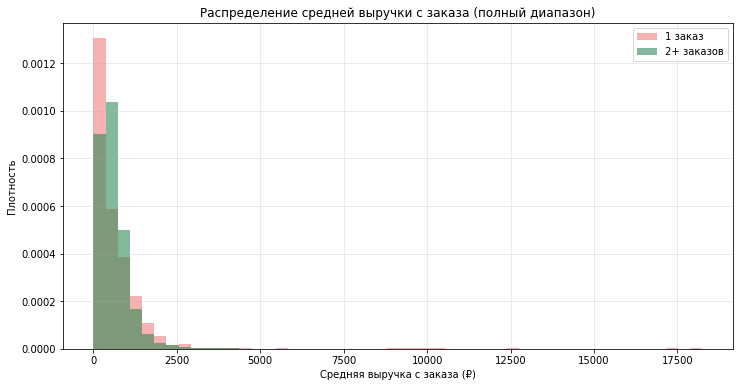

In [62]:
plt.figure(figsize=(12, 6))
plt.hist(one_time_users, bins=50, alpha=0.6, label='1 заказ', color='lightcoral', density=True)
plt.hist(repeat_users, bins=50, alpha=0.6, label='2+ заказов', color='seagreen', density=True)
plt.title('Распределение средней выручки с заказа (полный диапазон)')
plt.xlabel('Средняя выручка с заказа (₽)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Так как график распределения имеет длинный "правый хвост" - небольшое количество редких заказов с очень высокой выручкой. Эти значения сильно растягивают масштаб гистограммы и сжимают основную массу наблюдений в узкий участок, что затрудняет визуальный анализ поведения большинства пользователей. В связи с этим ось X ограничим диапазоном от 0 до 3000 ₽.

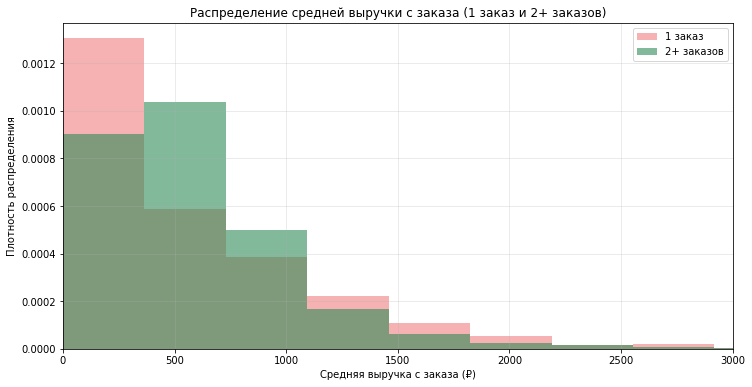

In [63]:
plt.figure(figsize=(12, 6))

plt.hist(one_time_users, bins=50, alpha=0.6, label='1 заказ', color='lightcoral', density=True)
plt.hist(repeat_users, bins=50, alpha=0.6, label='2+ заказов', color='seagreen', density=True)

plt.title('Распределение средней выручки с заказа (1 заказ и 2+ заказов)')
plt.xlabel('Средняя выручка с заказа (₽)')
plt.ylabel('Плотность распределения')
plt.xlim(0, 3000)  # Ограничиваем ось X до 3000 ₽
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**В каких диапазонах средней выручки концентрируются пользователи из каждой группы?**

Пользователи, совершившие 1 заказ, концентрируются в диапазоне 0–500 ₽, пик примерно на 300 ₽.

Пользователи, совершившие 2 и более заказа, — в диапазоне 400–1000 ₽, и распределение смещено вправо (в сторону более высокой выручки).

**Есть ли различия между группами?**

Да, пользователи, вернувшиеся на платформу, имеют выше среднюю выручку с заказа.
Это может говорить о том, что чем выше чек пользователя, тем больше вероятность повторного визита.

---

**Задача 11.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [64]:
# Подготовим данные
mid_loyal = user_profile.query('total_orders >= 2 and total_orders < 5')['avg_revenue']
high_loyal = user_profile.query('total_orders >= 5')['avg_revenue']

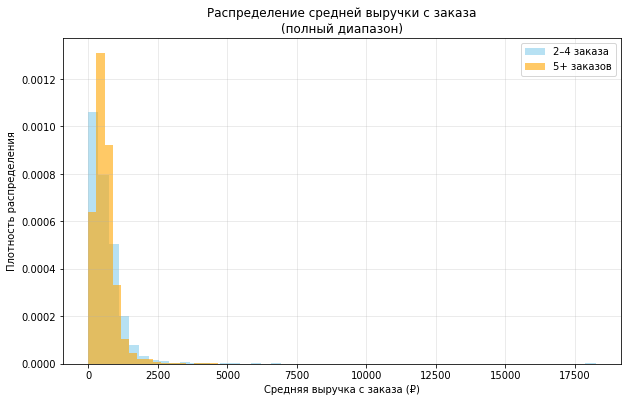

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(mid_loyal, bins=50, alpha=0.6, label='2–4 заказа', color='skyblue', density=True)
plt.hist(high_loyal, bins=50, alpha=0.6, label='5+ заказов', color='orange', density=True)

plt.title('Распределение средней выручки с заказа\n(полный диапазон)')
plt.xlabel('Средняя выручка с заказа (₽)')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Так как график распределения имеет длинный "правый хвост" - небольшое количество редких заказов с очень высокой выручкой. Эти значения сильно растягивают масштаб гистограммы и сжимают основную массу наблюдений в узкий участок, что затрудняет визуальный анализ поведения большинства пользователей. В связи с этим ось X ограничим диапазоном от 0 до 3000 ₽.

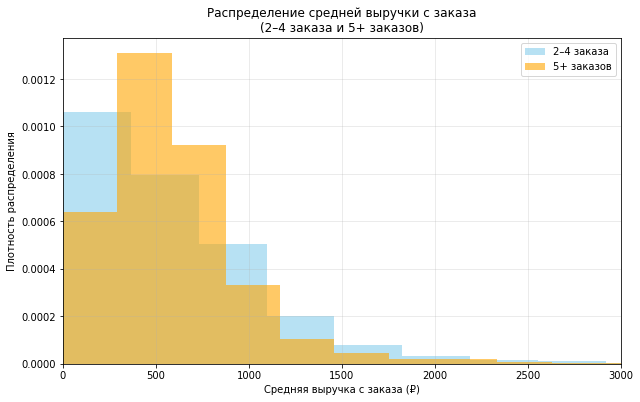

In [66]:
# Построим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(mid_loyal, bins=50, alpha=0.6, label='2–4 заказа', color='skyblue', density=True)
plt.hist(high_loyal, bins=50, alpha=0.6, label='5+ заказов', color='orange', density=True)

plt.title('Распределение средней выручки с заказа\n(2–4 заказа и 5+ заказов)')
plt.xlabel('Средняя выручка с заказа (₽)')
plt.ylabel('Плотность распределения')
plt.xlim(0, 3000)  # ограничиваем до 3000 ₽ для читаемости
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?**

Да, различия есть, но они умеренные.

Что видно на графике:

Обе группы — пользователи с 2–4 заказами и с 5+ заказами — концентрируются в диапазоне до 1000 ₽ средней выручки с заказа.

Однако у пользователей с 5+ заказами (оранжевый цвет)
распределение смещено немного вправо, что означает чуть более высокую среднюю выручку.

Также видно, что у этой группы реже встречаются низкие значения (до 200 ₽) и чаще — заказы с выручкой 800–1500 ₽.

Вывод:
пользователи, совершающие 5 и более заказов, в среднем тратят немного больше на один заказ,
но различия не резкие — диапазоны значений сильно пересекаются.
Это говорит о том, что частота возвратов не напрямую зависит от среднего чека,
а скорее связана с другими факторами — интересом к мероприятиям, привычкой пользоваться сервисом и удобством покупки.

---

**Задача 12.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [67]:
# Разделим пользователей по количеству билетов в заказе на сегменты
bins = [0, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']

user_profile['tickets_segment'] = pd.cut(user_profile['avg_tickets'], bins=bins, labels=labels, right=False)

In [68]:
# Посчитаем число пользователей и долю вернувшихся
tickets_stats = (
    user_profile.groupby('tickets_segment')
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)

tickets_stats['return_rate'] = (tickets_stats['return_rate'] * 100).round(2)
tickets_stats['users_share'] = (tickets_stats['users_count'] / tickets_stats['users_count'].sum() * 100).round(2)

tickets_stats

,users_count,return_rate,users_share
tickets_segment,,,
1–2 билета,2418,50.87,11.13
2–3 билета,9533,74.03,43.89
3–5 билетов,9080,54.98,41.81
5+ билетов,688,19.33,3.17


**Как распределены пользователи по сегментам?**

Пользователи распределены неравномерно.
Около 85 % всех клиентов находятся в двух сегментах:

2–3 билета (43.9%).
3–5 билетов (41.8%).
Сегменты с 1–2 и 5+ билетами составляют лишь малую часть (всего около 14%).

**Есть ли сегменты с аномально высокой или низкой долей повторных покупок?**

Да.
Аномально высокая доля возвратов — у сегмента 2–3 билета (74%).
Эти пользователи наиболее склонны возвращаться и делать повторные заказы.
Аномально низкая доля возвратов — у сегмента 5+ билетов (19%).
Вероятно, это организаторы или разовые покупатели для групповых мероприятий.

---

####  Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 13.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [69]:
# Создаём названия дней
weekday_map = {
    0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг',
    4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'
}

In [70]:
# Добавляем день недели первой покупки
filtered_profile = filtered_profile.copy()
filtered_profile['first_order_weekday'] = filtered_profile['first_order_dt'].dt.dayofweek
filtered_profile['first_order_weekday_name'] = filtered_profile['first_order_weekday'].map(weekday_map)

In [71]:
weekday_stats = (
    filtered_profile.groupby('first_order_weekday_name', as_index=False)
    .agg({'user_id': 'count', 'is_two': 'mean'})
    .rename(columns={'user_id': 'users_count', 'is_two': 'return_rate'})
)

In [72]:
# Перевод доли в проценты
weekday_stats['return_rate'] = (weekday_stats['return_rate'] * 100).round(2)

In [73]:
# Упорядочиваем по календарной логике (а не по алфавиту)
weekday_order = [
    'Понедельник', 'Вторник', 'Среда', 'Четверг',
    'Пятница', 'Суббота', 'Воскресенье'
]
weekday_stats['first_order_weekday_name'] = pd.Categorical(
    weekday_stats['first_order_weekday_name'],
    categories=weekday_order,
    ordered=True
)

# Сортировка по порядку и сброс индекса
weekday_stats = (
    weekday_stats
    .sort_values('first_order_weekday_name')
    .reset_index(drop=True)
)

display(weekday_stats)

,first_order_weekday_name,users_count,return_rate
0,Понедельник,2872,63.09
1,Вторник,3083,61.60
2,Среда,3034,62.03
3,Четверг,3119,59.89
4,Пятница,3277,59.99
5,Суббота,3327,62.70
6,Воскресенье,2789,60.27


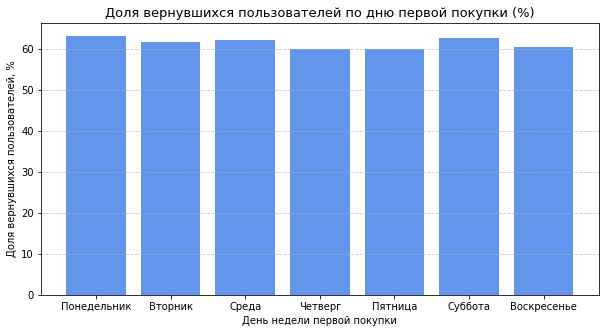

In [74]:
# 📈 Визуализация
plt.figure(figsize=(10,5))
plt.bar(weekday_stats['first_order_weekday_name'], weekday_stats['return_rate'], color='cornflowerblue')
plt.title('Доля вернувшихся пользователей по дню первой покупки (%)', fontsize=13)
plt.xlabel('День недели первой покупки')
plt.ylabel('Доля вернувшихся пользователей, %')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Анализ распределения показывает, что день недели первой покупки оказывает лишь незначительное влияние на вероятность повторного заказа.

Средние значения возврата колеблются в узком диапазоне от 59.9% до 63.1%, что говорит о стабильном поведении пользователей вне зависимости от дня недели.

Незначительно более высокая доля возвратов наблюдается у пользователей, сделавших первый заказ в понедельник (63.1%) и в субботу (62.7%).

Наименьший процент возврата отмечается для четверга (59.9%) и пятницы (59.99%), однако разница менее 3 процентов, что статистически несущественно.

**Вывод:**
День недели, в который пользователь впервые совершил покупку, не оказывает заметного влияния на вероятность его возврата. Поведение пользователей относительно равномерно, что может говорить о стабильном интересе к мероприятиям на протяжении всей недели.

---

**Задача 14.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [75]:
# Группы пользователей по количеству заказов
groups = [
    ('2–4 заказа', (filtered_profile['total_orders'] >= 2) & (filtered_profile['total_orders'] < 5)),
    ('5+ заказов', filtered_profile['total_orders'] >= 5)
]

In [76]:
# Рассчитаем средние интервалы между заказами
interval_stats = []
for name, condition in groups:
    subset = filtered_profile[condition & filtered_profile['avg_days_between'].notna()]
    interval_stats.append({
        'group': name,
        'users_count': len(subset),
        'avg_interval_days': subset['avg_days_between'].mean().round(2),
        'median_interval_days': subset['avg_days_between'].median().round(2)
    })

In [77]:
# Сформируем таблицу
interval_df = pd.DataFrame(interval_stats)
interval_df

,group,users_count,avg_interval_days,median_interval_days
0,2–4 заказа,7088,21.44,9.0
1,5+ заказов,6106,9.95,8.2


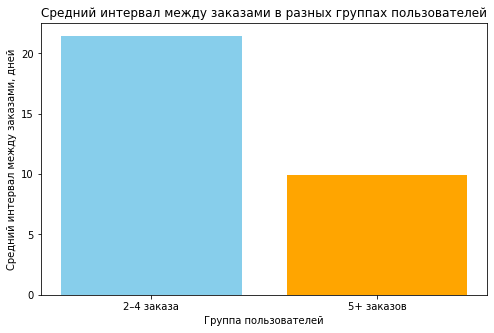

In [78]:
plt.figure(figsize=(8,5))
plt.bar(interval_df['group'], interval_df['avg_interval_days'], color=['skyblue', 'orange'])
plt.title('Средний интервал между заказами в разных группах пользователей')
plt.xlabel('Группа пользователей')
plt.ylabel('Средний интервал между заказами, дней')
plt.show()

**Вывод:**

Пользователи с 5+ заказами совершают покупки гораздо чаще:
средний интервал между заказами почти в 2 раза меньше, чем у группы 2–4 заказа.

Это говорит о более высокой вовлечённости и лояльности: чем чаще человек покупает, тем меньше времени он ждёт между заказами.

Следовательно, интервал между покупками — один из ключевых индикаторов удержания: чем он меньше, тем выше вероятность, что пользователь продолжит использовать сервис.

---

####  Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 15:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

**Примечание:**

Phi_K чувствителен к выбросам и аномально большим значениям.

Поэтому для корректного анализа связей нужно использовать очищенный набор — filtered_profile.

In [79]:
# Определим признаки для анализа
corr_cols = [
    'total_orders', # целевой показатель
    'avg_revenue', # средняя выручка
    'avg_tickets', # среднее число билетов
    'avg_days_between', # средний интервал между покупками
    'first_device', # тип устройства первого заказа
    'first_region', # регион первого заказа
    'first_service', # билетный оператор
    'first_genre' # тип первого мероприятия
]

In [80]:
# Расчёт матрицы Phi_K (универсальный коэффициент корреляции)
phik_matrix = filtered_profile[corr_cols].phik_matrix(
    interval_cols=['total_orders', 'avg_revenue', 'avg_tickets', 'avg_days_between']
)

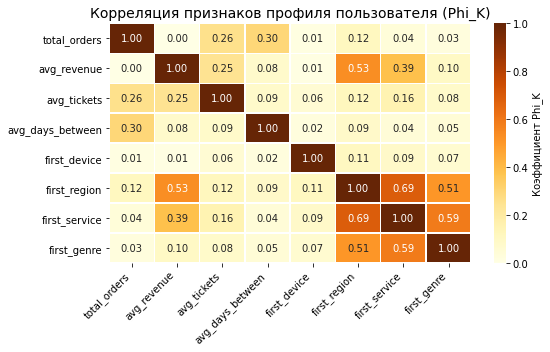

In [81]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    phik_matrix,
    annot=True, fmt=".2f", cmap="YlOrBr",
    linewidths=0.5, cbar_kws={'label': 'Коэффициент Phi_K'}
)
plt.title('Корреляция признаков профиля пользователя (Phi_K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [82]:
# Проверим распределение количества заказов по пользователям
filtered_profile['total_orders'].value_counts(bins=[1,2,5,10,50,100,500])

(0.999, 2.0]      11866
(2.0, 5.0]         4499
(5.0, 10.0]        2373
(10.0, 50.0]       2279
(50.0, 100.0]       348
(100.0, 500.0]      136
Name: total_orders, dtype: int64

In [83]:
# Добавим сегмент по числу заказов
filtered_profile['order_segment'] = pd.cut(
    filtered_profile['total_orders'],
    bins=[0, 1, 4, 10000],
    labels=['1 заказ', '2–4 заказа', '5+ заказов']
)

# Проверим распределение по сегментам
filtered_profile['order_segment'].value_counts()

1 заказ       8307
2–4 заказа    7088
5+ заказов    6106
Name: order_segment, dtype: int64

Теперь выполним корреляцию внутри каждого сегмента:

In [84]:
# Определяем признаки для анализа
corr_cols = [
    'total_orders', 'avg_revenue', 'avg_tickets', 'avg_days_between',
    'first_device', 'first_region', 'first_service', 'first_genre'
]


📊 Корреляция для сегмента: 1 заказ


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable total_orders for analysis 1. Dropping this column
  warnings.warn(


<Figure size 504x360 with 0 Axes>

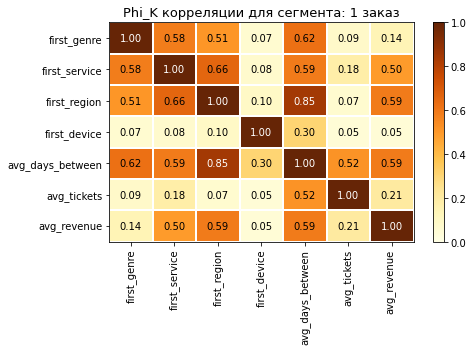


📊 Корреляция для сегмента: 2–4 заказа


<Figure size 504x360 with 0 Axes>

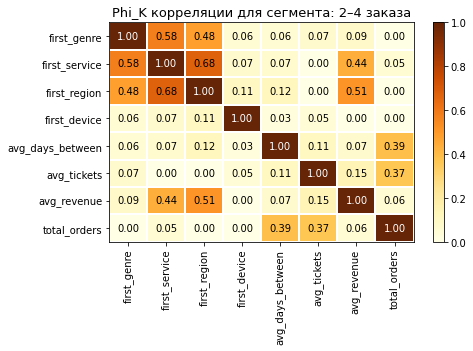


📊 Корреляция для сегмента: 5+ заказов


<Figure size 504x360 with 0 Axes>

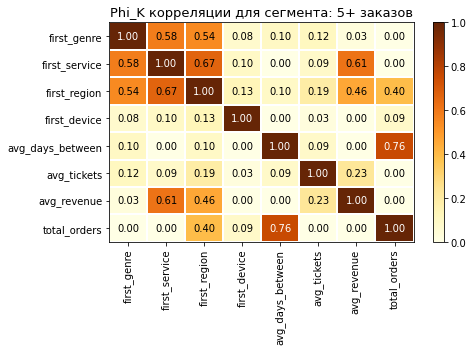

In [85]:
# Корреляция Phi_K по сегментам
for segment in filtered_profile['order_segment'].unique():
    segment_df = filtered_profile[filtered_profile['order_segment'] == segment]
    print(f"\n📊 Корреляция для сегмента: {segment}")
    
    phik_seg = segment_df[corr_cols].phik_matrix(
        interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between']
    )
    
    plt.figure(figsize=(7, 5))
    plot_correlation_matrix(
        phik_seg.values,
        x_labels=phik_seg.columns,
        y_labels=phik_seg.index,
        vmin=0, vmax=1,
        color_map='YlOrBr'
    )
    plt.title(f'Phi_K корреляции для сегмента: {segment}', fontsize=13)
    plt.show()

**Анализ тепловой карты**


Phi-корреляция показывает степень взаимосвязанности между признаками, но не задаёт направление
монотонного изменения (как это делает, например, Пирсон для количественных переменных).  
Поэтому корректно интерпретировать только **силу связи**, а не делать выводы вида
«при увеличении одного показателя увеличивается другой».

Исходя из этого, рассмотрим взаимосвязи с признаком total_orders:

- **avg_days_between — 0.30**  
  Умеренная взаимосвязь. Значения признака связаны с количеством заказов, но корреляция не
  указывает, как именно меняется один показатель при изменении другого.

- **avg_tickets — 0.26**  
  Также умеренная взаимосвязанность: количество билетов в заказе и общее число заказов
  статистически сопутствуют друг другу, но нельзя говорить о прямой монотонной зависимости.

- **first_region — 0.12**  
  Слабая взаимосвязь между регионом первого заказа и количеством заказов.

- **avg_revenue — 0.00**  
  Связь отсутствует — значения средней выручки никак не ассоциируются с общим количеством заказов.

- **first_device, first_service, first_genre — <0.1**  
  Практически нулевая связь — первые действия пользователя (жанр, устройство, сервис)
  не демонстрируют статистически значимой сопряжённости с количеством заказов.

**Итог:** признаки активности пользователя (интервалы между заказами, размер покупки) имеют более
высокую взаимосвязь с количеством заказов, чем категориальные признаки. Однако направление или
монотонность зависимости на основе phi-корреляции интерпретировать нельзя.


## Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.


### Подготовка и предобработка данных  
В проекте проанализированы **290 611** заказов сервиса Яндекс Афиша.  
Основные шаги подготовки:
- Привели выручку к рублям по курсу тенге (данные из `final_tickets_tenge_df.csv`).
- Исключили выбросы по выручке (свыше 99-го перцентиля).
- После очистки и фильтрации осталось **~287 000 заказов** и **~21 700 уникальных пользователей**.
- Проверили типы данных и пропуски (остались только в `days_since_prev` — логично для первой покупки).

---

###  Общая характеристика пользователей  
- Среднее число заказов на пользователя — **13**, медианное — **2** (распределение с сильным перекосом).  
- Доля пользователей, совершивших ≥ 2 заказа — **61 %**; ≥ 5 заказов — **29 %**.  
- Средняя выручка с заказа — **≈ 575 ₽**, среднее количество билетов — **2.7**.

---

### Поведение пользователей и возвраты  
- Большинство пользователей совершают первый заказ на **концерты (43 %)**, чаще с **мобильных устройств (83 %)**, преимущественно в **Каменевском регионе (33 %)**, у оператора **«Билеты без проблем» (24 %)**.  
- Пользователи, начавшие с **театра** и **выставок**, возвращаются чаще (≈ 64 %), чем в среднем по выборке (≈ 61 %).  
- Более высокая доля возвратов наблюдается среди:
  - пользователей **desktop-устройств** (64 % против 61 % у мобильных);
  - клиентов из **Светополянского округа** (≈ 67 %);
  - покупателей у оператора **«Край билетов»** (≈ 66 %).

---

### Финансовое и поведенческое вовлечение  
- Вернувшиеся пользователи имеют немного **высшую среднюю выручку** (350–600 ₽ за заказ).  
- Пользователи с **5+ заказами** чаще совершают заказы средней стоимости.  
- Наибольшая доля повторных клиентов среди тех, кто покупает **2–3 билета** — **74 %**.

---

### Временные характеристики и удержание  
- **День недели** первой покупки почти не влияет на возврат — разброс не превышает 3 %  
- **Средний интервал между покупками:**
  - 2–4 заказа → ≈ 21 день  
  - 5+ заказов → ≈ 9 дней  
  → чем короче интервалы между заказами, тем выше удержание.  
- **Лайфтайм** (время между первой и последней покупкой) — в среднем **≈ 39 дней**, но с большим разбросом (до 150 дней у активных пользователей).

---

###  Корреляционный анализ (Phi_K)

Наибольшая связь с количеством заказов (`total_orders`):

| Признак | Коэффициент Phi_K | Интерпретация |
|:--|:--:|:--|
| `avg_days_between` | **0.30** | Короткие интервалы между заказами связаны с высокой частотой покупок |
| `avg_tickets` | **0.26** | Пользователи, покупающие больше билетов, чаще возвращаются |
| `avg_revenue` | **0.00** | Средняя выручка напрямую не влияет на количество заказов |
| Категориальные признаки (`region`, `service`, `genre`) | < 0.1 | Слабая или отсутствующая связь |

---

###  Рекомендации маркетинговой команде

1. **Фокусироваться на удержании активных клиентов** — особенно тех, кто покупает 2–3 билета (самая лояльная аудитория).  
2. **Стимулировать повторные покупки** в течение **10–20 дней** после первого заказа — это «золотое окно» для удержания.  
3. **Сегментированные маркетинговые кампании:**
   - по типу события (театр, выставки — высокая вероятность возврата);  
   - по оператору («Край билетов», «Весь в билетах» — лояльные клиенты).  
4. **Развивать desktop-канал** — пользователи компьютеров чаще возвращаются.  
5. **Продвигать мультибилетные покупки (2–3 билета)** — они связаны с высокой вовлечённостью.  
6. **Реактивировать пользователей** с интервалом более 20 дней между заказами (email- и push-кампании).

---

###  Итог
Анализ показал, что **удержание пользователей зависит прежде всего от частоты покупок и вовлечённости**:  
- короткие интервалы между заказами и групповые покупки — ключевые признаки лояльности;  
- тип события и билетный оператор влияют на возврат, но слабее.  

Главный потенциал роста — **работа с пользователями после первой покупки и поддержка активности в первые недели**.

## Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/KUdachin/afisha-eda-project.git